In [1]:
import scanpy as sc
import scvelo as scv
import latentvelo as ltv
import numpy as np
import pandas as pd

Global seed set to 0


In [2]:
S3 = sc.read('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/S3_anndata 1.h5ad')
scv.pp.remove_duplicate_cells(S3)
S3.obs['cell_type'] = 'hPSC fetal lung cells'
S3.obs['batch'] = 'hPSC fetal lung cells'

In [3]:
# get clustering
cluster_S3 = sc.read('data/S3_unintegrated_clusters.h5ad')

In [4]:
barcode = []
origin = []
for i in range(len(S3)):
    barcode.append(S3.uns['cell_origin'][i][0] + '_' + S3.obs.index.values[i])
    origin.append(S3.uns['cell_origin'][i][0])
S3.obs['barcode'] = barcode
S3.obs['origin'] = origin

In [5]:
umap = []
louvain = []
selected = []
for i in range(len(S3)):
    barcode = S3.obs.iloc[i].barcode
    origin = S3.obs.iloc[i].origin
    if barcode in cluster_S3.obs.index.values:
        louvain.append(cluster_S3.obs.loc[barcode].louvain)
        
        idx = np.where(cluster_S3.obs.index.values == barcode)[0][0]
        umap.append(cluster_S3.obsm['X_umap'][idx])
        selected.append(i)

In [6]:
S3 = S3[selected]

In [7]:
S3.obs['louvain'] = np.array(louvain)
S3.obsm['X_umap'] = np.array(umap)

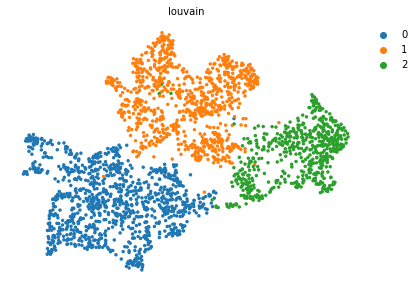

In [8]:
scv.pl.umap(S3, color='louvain')

In [9]:
scv.pp.filter_genes(S3, min_shared_cells=30)
scv.pp.filter_and_normalize(S3)
scv.pp.filter_genes_dispersion(S3, n_top_genes = 3000, flavor='cell_ranger', log=False)

Filtered out 27359 genes that are detected in less than 30 cells (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
Extracted 3000 highly variable genes.


In [11]:
#modified preprocessing from latentvelo
import numpy as np
import scipy as scp
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import scanpy as sc
import scvelo as scv

def get_weight(x, y=None, perc=95):
    from scipy.sparse import issparse

    xy_norm = np.array(x.A if issparse(x) else x)
    if y is not None:
        if issparse(y):
            y = y.A
        xy_norm = xy_norm / np.clip(np.max(xy_norm, axis=0), 1e-3, None)
        xy_norm += y / np.clip(np.max(y, axis=0), 1e-3, None)

    if isinstance(perc, int):
        weights = xy_norm >= np.percentile(xy_norm, perc, axis=0)
    else:
        lb, ub = np.percentile(xy_norm, perc, axis=0)
        weights = (xy_norm <= lb) | (xy_norm >= ub)
    
    return weights

def R2(residual, total):
    r2 = np.ones(residual.shape[1]) - \
        np.sum(residual * residual, axis=0) / \
            np.sum(total * total, axis=0)
    r2[np.isnan(r2)] = 0
    return r2

def compute_velocity_genes(adata_raw, n_top_genes, r2_adjust = True, inplace=True,
                           min_ratio=0.01, min_r2=0.01, max_r2=0.95, perc=[5, 95]):
    
    adata = adata_raw.copy()
    
    fit_offset=False
    vkey='velocity'
    
    Ms = adata_raw.layers['Ms'].copy()
    Mu = adata_raw.layers['Mu'].copy()
    n_obs, n_vars = Ms.shape
    n_var = n_vars

    gamma = np.zeros(n_vars)
    r2 = np.zeros(n_vars)
    velocity_genes = np.ones(n_vars)
    residual_scale = np.zeros([n_obs, n_vars])

    # need get_weight function
    weights = get_weight(Ms, Mu, perc=95)

    Ms_quantile, Mu_quantile = weights * Ms, weights * Mu

    # linear slope using quantiles (weights)
    gamma_quantile = np.sum(Mu_quantile * Ms_quantile, axis=0) / np.sum(Ms_quantile * Ms_quantile, axis=0)
    
    scaling = np.std(Mu, axis=0) / np.std(Ms, axis=0)
    
    # switch back to non quantile
    if r2_adjust:
        Ms, Mu = Ms, Mu

    # non quantile slope
    gamma_ref = np.sum(Mu * Ms, axis=0) / np.sum(Ms * Ms, axis=0)
    residual_scale = Mu - gamma_ref * Ms
    
    r2 = R2(residual_scale, total=Mu - np.mean(Mu, axis=0))
    
    # select genes
    velocity_genes = np.ones(n_var)
    velocity_genes = (
        (r2 > min_r2)
        & (r2 < max_r2)
        & (gamma_quantile > min_ratio)
        & (gamma_ref > min_ratio)
        & (np.max(Ms > 0, axis=0) > 0)
        & (np.max(Mu > 0, axis=0) > 0)
    )

    # filter noisy genes
    if r2_adjust:
        
        lb, ub = np.nanpercentile(scaling, [10, 90])
        velocity_genes = (
            velocity_genes
            & (scaling > np.min([lb, 0.03]))
            & (scaling < np.max([ub, 3]))
        )
    
    nonzero_s, nonzero_u = Ms > 0, Mu > 0
    weights = np.array(nonzero_s & nonzero_u, dtype=bool)
    nobs = np.sum(weights, axis=0)
        
    velocity_genes = velocity_genes & (nobs > 0.05 * Ms.shape[1])
    
    if inplace:
        adata_raw.var['velocity_genes'] = velocity_genes
    else:
        return adata.var['velocity_genes']

def preprocessed_clean(adata, spliced_key = 'spliced', unspliced_key = 'unspliced', batch_key = None, root_cells = None, terminal_cells=None,
                       normalize_library=True, n_top_genes = 2000, smooth = True, umap=False, log=True, r2_adjust=True, share_normalization=False, center=False, celltype_key=None, recompute_neighbors=False, recompute_pca=False, recompute_moments=True, n_neighbors=30):  

    if normalize_library:
        spliced_library_sizes = adata.layers[spliced_key].sum(1)
        unspliced_library_sizes = adata.layers[unspliced_key].sum(1)
        
        if len(spliced_library_sizes.shape) == 1:
            spliced_library_sizes = spliced_library_sizes[:,None]
        if len(unspliced_library_sizes.shape) == 1:
            unspliced_library_sizes = unspliced_library_sizes[:,None]
        
        if share_normalization:
            library_size = spliced_library_sizes + unspliced_library_sizes

        if share_normalization:
            spliced_median_library_sizes = np.median(np.array(library_size)[:,0])
            unspliced_median_library_sizes = np.median(np.array(library_size)[:,0])
        else:
            spliced_median_library_sizes = np.median(np.array(spliced_library_sizes)[:,0])
            unspliced_median_library_sizes = np.median(np.array(unspliced_library_sizes)[:,0])
        
        spliced_all_size_factors = spliced_library_sizes/spliced_median_library_sizes
        unspliced_all_size_factors = unspliced_library_sizes/unspliced_median_library_sizes
        
        adata.layers[spliced_key] = adata.layers[spliced_key]/spliced_all_size_factors
        adata.layers[unspliced_key] = adata.layers[unspliced_key]/unspliced_all_size_factors
        
        adata.obs['spliced_size_factor'] = spliced_library_sizes
        adata.obs['unspliced_size_factor'] = unspliced_library_sizes

    else:
        adata.obs['spliced_size_factor'] = 1
        adata.obs['unspliced_size_factor'] = 1
    
    if scp.sparse.issparse(adata.layers[spliced_key]):
        adata.layers[spliced_key] = adata.layers[spliced_key].todense()
        adata.layers[unspliced_key] = adata.layers[unspliced_key].todense()
        
    else:
        adata.layers[spliced_key] = scp.sparse.csr_matrix(adata.layers[spliced_key]).todense()
        adata.layers[unspliced_key] = scp.sparse.csr_matrix(adata.layers[unspliced_key]).todense()  
    
    # include raw counts
    adata.layers['spliced_counts'] = np.array(adata.layers[spliced_key])
    adata.layers['unspliced_counts'] = np.array(adata.layers[unspliced_key])

    adata.layers['mask_spliced'] = np.array((adata.layers[spliced_key] > 0) + (adata.layers[unspliced_key] > 0))*1 #
    adata.layers['mask_unspliced'] = np.array((adata.layers[unspliced_key] > 0) + (adata.layers[spliced_key] > 0))*1 # + 

    if recompute_pca:
        sc.pp.pca(adata)
    if recompute_neighbors:
        scv.pp.neighbors(adata, n_pcs=30, n_neighbors=n_neighbors)
    if recompute_moments:
        scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
    
    adata.obsp['adj'] = adata.obsp['connectivities']
    
    compute_velocity_genes(adata, n_top_genes=n_top_genes,r2_adjust=r2_adjust)
    
    if smooth:
        adata.uns['scale_spliced'] = 4*(1+np.std(adata.layers['Ms'], axis=0)[None])
        adata.uns['scale_unspliced'] = 4*(1+np.std(adata.layers['Mu'], axis=0)[None])

        adata.layers['spliced_raw'] = np.array(adata.layers['spliced'])
        adata.layers['unspliced_raw'] = np.array(adata.layers['unspliced'])

        if center:
            
            adata.uns['mean_spliced'] = np.mean(adata.layers['Ms'], axis=0)[None]
            adata.uns['mean_unspliced'] = np.mean(adata.layers['Mu'], axis=0)[None]
            
            adata.layers['spliced'] = np.array((adata.layers['Ms'] - adata.uns['mean_spliced'])/adata.uns['scale_spliced'])
            adata.layers[spliced_key] = np.array((adata.layers['Ms'] - adata.uns['mean_spliced'])/adata.uns['scale_spliced'])
            adata.layers['unspliced'] = np.array((adata.layers['Mu'] - adata.uns['mean_unspliced'])/adata.uns['scale_unspliced'])
            adata.layers[unspliced_key] = np.array((adata.layers['Mu'] - adata.uns['mean_unspliced'])/adata.uns['scale_unspliced'])
        else:
            adata.layers['spliced'] = np.array(adata.layers['Ms']/adata.uns['scale_spliced'])
            adata.layers[spliced_key] = np.array(adata.layers['Ms']/adata.uns['scale_spliced'])
            adata.layers['unspliced'] = np.array(adata.layers['Mu']/adata.uns['scale_unspliced'])
            adata.layers[unspliced_key] = np.array(adata.layers['Mu']/adata.uns['scale_unspliced'])
        
    else:
        adata.uns['scale_spliced'] = 4*(1+np.std(adata.layers[spliced_key], axis=0)[None])
        adata.uns['scale_unspliced'] = 4*(1+np.std(adata.layers[unspliced_key], axis=0)[None])
        
        adata.layers['spliced'] = adata.layers[spliced_key]/adata.uns['scale_spliced']
        adata.layers[spliced_key] = adata.layers[spliced_key]/adata.uns['scale_spliced']
        adata.layers['unspliced'] = adata.layers[unspliced_key]/adata.uns['scale_unspliced']
        adata.layers[unspliced_key] = adata.layers[unspliced_key]/adata.uns['scale_unspliced']
    
    
    # use label encoder
    if batch_key != None:
        label_encoder = LabelEncoder()
        batch_id = label_encoder.fit_transform(adata.obs[batch_key])
        adata.obs['batch_id'] = batch_id

        onehotbatch = OneHotEncoder(sparse=False).fit_transform(batch_id[:,None])
        adata.obsm['batch_onehot'] = onehotbatch
        
    else:
        batch_key = 'batch_id'
        adata.obs[batch_key] = 0
        label_encoder = LabelEncoder()
        batch_id = label_encoder.fit_transform(adata.obs[batch_key])
        adata.obs['batch_id'] = batch_id

        onehotbatch = OneHotEncoder(sparse=False).fit_transform(batch_id[:,None])
        adata.obsm['batch_onehot'] = onehotbatch
    
    label_encoder = LabelEncoder()
    celltype = label_encoder.fit_transform(adata.obs[celltype_key])
    adata.obs['celltype'] = celltype
    
    onehotcelltype = OneHotEncoder(sparse=False).fit_transform(celltype[:,None])
    adata.obsm['celltype'] = onehotcelltype
    

    if celltype_key != None:
        label_encoder = LabelEncoder()
        celltype = label_encoder.fit_transform(adata.obs[celltype_key])
        adata.obs['celltype_id'] = celltype
    else:
        adata.obs['celltype_id'] = 0

    
    if root_cells == 'precalced':
        print('using precalced root cells')
    elif celltype_key != None and root_cells != None:
        adata.obs['root'] = 0
        adata.obs['root'][adata.obs[celltype_key] == root_cells] = 1
    else:
        adata.obs['root'] = 0
    
    if terminal_cells == 'precalced':
        print('using precalced terminal cells')
    elif celltype_key != None and terminal_cells != None:
        adata.obs['terminal'] = 0
        if type(terminal_cells) == list:
            for c in terminal_cells:
                adata.obs['terminal'][adata.obs[celltype_key] == c] = 1
        else:
            adata.obs['terminal'][adata.obs[celltype_key] == terminal_cells] = 1
    else:
        adata.obs['terminal'] = 0  


In [13]:
preprocessed_clean(S3, celltype_key='louvain', normalize_library=False, 
                  recompute_pca=True, recompute_neighbors=True, recompute_moments=True,
                  n_neighbors=100)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [25]:
model = ltv.models.VAE(observed=3000, latent_dim=20, encoder_hidden=25, zr_dim=1, h_dim=1)

gc.collect()
epochs, val_ae, val_traj = ltv.train(model, S3, epochs=50, batch_size = 500,
                                     name='S3',
                                     grad_clip=100,
                                     learning_rate=1e-2)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Warning, folder already exists. This may overwrite a previous fit.
1640 velocity genes used
epoch 0, full loss 706.479, val loss 874.540, recon MSE 47.074, traj MSE 32.752, reg loss -1.993
epoch 1, full loss 695.122, val loss 625.115, recon MSE 17.069, traj MSE 14.638, reg loss -2.202
epoch 2, full loss 639.167, val loss 566.344, recon MSE 11.651, traj MSE 9.534, reg loss -2.191
epoch 3, full loss 542.972, val loss 517.935, recon MSE 7.530, traj MSE 6.046, reg loss -2.097
epoch 4, full loss 485.956, val loss 468.431, recon MSE 7.387, traj MSE 4.814, reg loss -2.294
epoch 5, full loss 435.991, val loss 422.236, recon MSE 6.443, traj MSE 4.390, reg loss -2.349
epoch 6, full loss 383.442, val loss 374.159, recon MSE 6.162, traj MSE 4.102, reg loss -2.390
epoch 7, full loss 332.671, val loss 325.963, recon MSE 5.947, traj MSE 4.001, reg loss -2.475
epoch 8, full loss 279.097, val loss 278.110, recon MSE 6.026, traj MSE 3.927, reg loss -2.560
epoch 9, full loss 228.685, val loss 229.100, re

In [30]:
latent_adata = ltv.output_results(model, S3)

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocity graph (using 1/16 cores)


  0%|          | 0/2489 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [31]:
palette = {'hPSC organoids 0': '#1b9e77',
 'hPSC organoids 1': '#7570b3',
 'hPSC organoids 2': '#66a61e',
 'hPSC organoids 3': '#a6761d',
 'hPSC organoids 4': '#666666',
 'hPSC fetal lung cells 0': '#1f77b4',
 'hPSC fetal lung cells 1': '#ff7f0e',
 'hPSC fetal lung cells 2': '#2ca02c',
 'Fetal lung epithelia': '#D3D3D3'}

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
unint_cluster = []
for i in range(len(latent_adata)):
    unint_cluster.append('hPSC fetal lung cells ' + str(latent_adata.obs.iloc[i].louvain))
latent_adata.obs['unint_cluster'] = unint_cluster

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


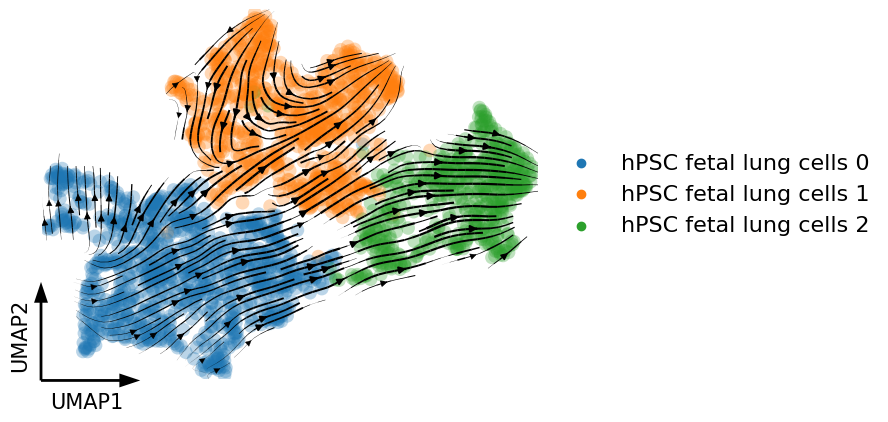

In [33]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['unint_cluster'], title='',
                                 frameon='artist', fontsize=18, #, 'exp_time'
                                cutoff_perc=0, legend_loc='right', legend_fontsize=16,
                                 ncols=1, palette=palette, rasterized=True)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file figures/hPSC_fetal_lung_velocity.svg


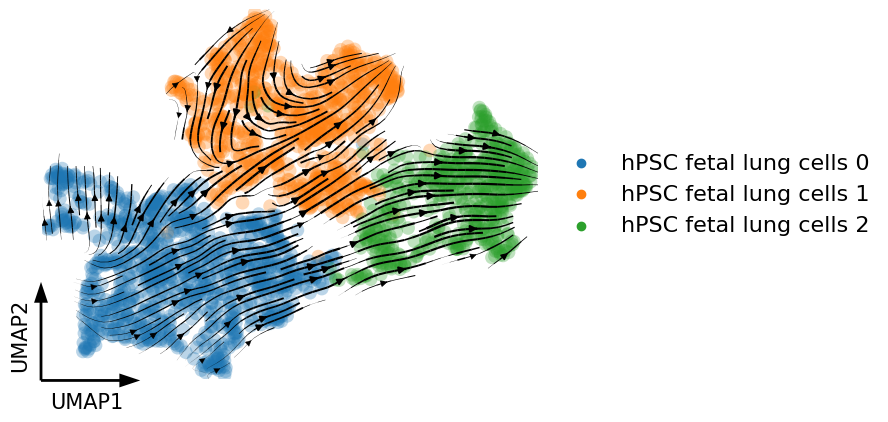

In [38]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['unint_cluster'], title='',
                                 frameon='artist', fontsize=18, #, 'exp_time'
                                cutoff_perc=0, legend_loc='right', legend_fontsize=16,
                                 ncols=1, palette=palette, rasterized=True,
                                save='figures/hPSC_fetal_lung_velocity.svg')